In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import legume 
legume.set_backend('autograd')
import legume.backend as bd
import numpy as np
import autograd.numpy as npa
from autograd import grad
import time
import matplotlib.pyplot as plt
import optomization

In [184]:
a = 455
phc = optomization.W1(NyChange=0,Ny=7,eps_slab=3.13,dslab=270/a)
gme = legume.GuidedModeExp(phc,3.01)
ks = npa.linspace(np.pi*.5,np.pi,100)
gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
gme.run(**gmeParams)

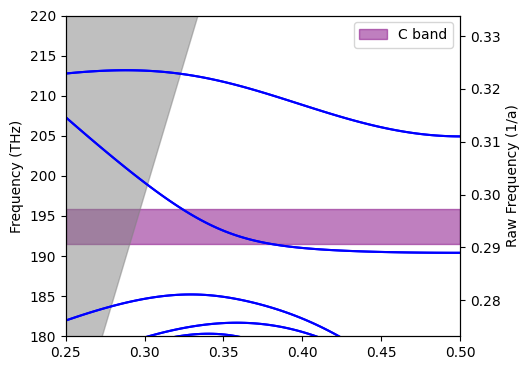

In [185]:
fconv = 299792458/a/1e-9/1e12
c_band_max = 195.9
c_band_min = 191.56

fig, ax1 = plt.subplots(figsize=(5.4, 3.8))

# Plot with frequency conversion on the left axis
ax1.plot(ks/np.pi/2, gme.freqs*fconv, color='b')
ax1.fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5,label='C band')
ax1.fill_between(ks/np.pi/2, ks*fconv/np.pi/2, np.max(ks)*fconv/np.pi/2, color='gray', alpha=.5)
ax1.set_ylim(180, 220)
ax1.set_xlim(0.25, 0.5)
ax1.set_ylabel('Frequency (THz)')

# Create a second y-axis without frequency conversion
ax2 = ax1.twinx()
ax2.plot(ks/np.pi/2, gme.freqs, color='b')
ax2.set_ylabel('Raw Frequency (1/a)')
# Match x-limits
ax2.set_ylim(ax1.get_ylim()[0]/fconv, ax1.get_ylim()[1]/fconv)
ax1.legend()
fig.tight_layout()
plt.show()

In [186]:
ngs = []
for i in range(len(ks)):
    ngs.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))

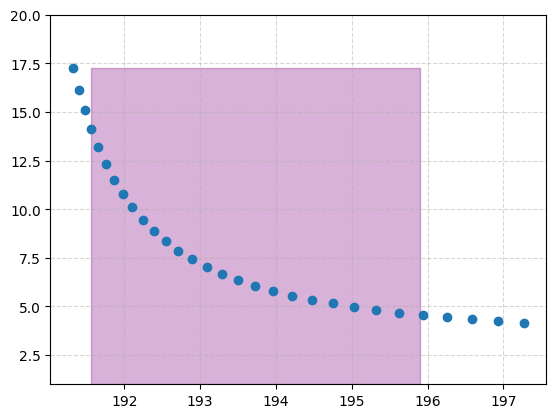

In [195]:
coff = 55
start = 25
plt.plot(gme.freqs[start:coff,14]*fconv,ngs[start:coff],'o')
plt.fill_between(np.linspace(c_band_min,c_band_max,coff), np.ones(coff), np.max(ngs[start:coff]), color='purple', alpha=0.3)
plt.grid(True,linestyle='--',alpha=0.5)
plt.ylim(1,20)
plt.show()


In [210]:
dirs = ['media/ng10_tests/test0.json','media/ng10_tests/test1.json','media/ng10_tests/test2.json']
vars_list = []
for dir in dirs:
    with open(dir, 'r') as f:
        data = json.load(f)
    vars_list.append(data[-1]['result']['x'])
vars_array = np.array(vars_list)


In [228]:
import copy
phcs = []
gmes = []
for vars in vars_array:
    phc = optomization.W1(vars=vars,Ny=7,eps_slab=3.13,dslab=270/455)
    gme = legume.GuidedModeExp(phc,3.01)
    ks = npa.linspace(np.pi*.5,np.pi,100)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
    gme.run(**gmeParams)
    phcs.append(copy.deepcopy(phc))
    gmes.append(copy.deepcopy(gme))


In [231]:
ngs = []
for gme in gmes:
    ng = []
    for i in range(len(gme.freqs[:,14])):
        ng.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))
    ngs.append(ng.copy())

496.0126909355437


IndexError: invalid index to scalar variable.

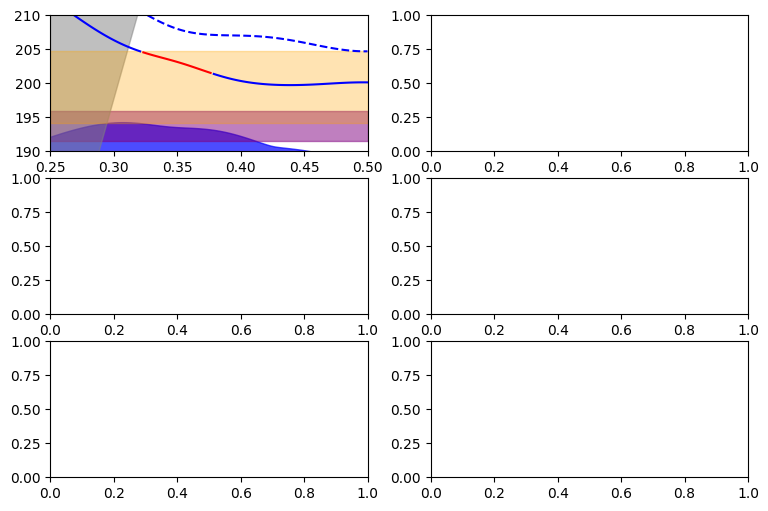

In [266]:

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fig, ax = plt.subplots(3,2,figsize=(9,6))
ngs = np.array(ngs)

startk = 29
endk = 51
for i,gme in enumerate(gmes):

    #print out the conversion factor to center the c band at the start of the region
    s = gme.freqs[startk,14]*fconv/c_band_max
    print((s**2)*455)

    #find the index that the frequency hits the light line
    light_line_index = np.argmin(np.abs(gme.freqs[:,14]-ks/np.pi/2))

    #get min and max frequency for the bandwidth
    bw_min = np.max(gme.freqs[:,14-1])*fconv
    bw_max = min(np.min(gme.freqs[:,14+1]),gme.freqs[light_line_index,14])*fconv

    #frequency plot
    # Plot the blue line outside [startk, endk]
    ax[i,0].plot(ks[:startk]/np.pi/2, gme.freqs[:startk,14]*fconv, color='b')
    ax[i,0].plot(ks[endk:]/np.pi/2, gme.freqs[endk:,14]*fconv, color='b')
    # Plot the red line within [startk, endk]
    ax[i,0].plot(ks[startk:endk]/np.pi/2, gme.freqs[startk:endk,14]*fconv, color='r')
    # The dashed blue line for the next band
    ax[i,0].plot(ks/np.pi/2, gme.freqs[:,15]*fconv, color='b', linestyle='--')
    ax[i,0].fill_between(ks/np.pi/2, gme.freqs[:,1]*fconv, gme.freqs[:,13]*fconv, color='b', alpha=.7)
    ax[i,0].fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5, label='C band')
    ax[i,0].fill_between(ks/np.pi/2, ks*fconv/np.pi/2, np.max(ks)*fconv/np.pi/2, color='gray', alpha=.5)
    ax[i,0].fill_between(ks/np.pi/2, bw_min, bw_max, color='orange', alpha=.3)
    ax[i,0].set_xlim(0.25, 0.5)
    ax[i,0].set_ylim(190, 210)

    #ng plot
    # Plot the blue curve outside [startk, endk]
    ax[i,1].plot(gme.freqs[:startk,14]*fconv, ngs[i][:startk], color='b')
    ax[i,1].plot(gme.freqs[endk:,14]*fconv, ngs[i][endk:], color='b')
    # Plot the red curve within [startk, endk]
    ax[i,1].plot(gme.freqs[startk:endk,14]*fconv, ngs[i][startk:endk], color='r')
    ax[i,1].fill_between(np.linspace(c_band_min, c_band_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='purple', alpha=0.3)
    ax[i,1].fill_between([gme.freqs[light_line_index,14]*fconv,220],[1,1],20,color='gray',alpha=0.5)
    ax[i,1].fill_between(np.linspace(bw_min, bw_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='orange', alpha=0.3)
    ax[i,1].grid(True,linestyle='--',alpha=0.5)
    ax[i,1].set_ylim(1,20)
    ax[i,1].set_xlim(185, 215)

#add labels and legends
ax[0,0].set_ylabel('Frequency (THz)',fontsize=16)
ax[2,1].set_xlabel('Frequency (THz)',fontsize=16)
ax[0,0].set_title('Frequency Plot',fontsize=16)
ax[0,1].set_title('NG Plot',fontsize=16)
ax[2,0].set_xlabel('Wavevector $\\tilde k$',fontsize=16)
# To set custom legend labels and colors, define proxy artists for the legend:
legend_handles = [
    mpatches.Patch(color='purple', alpha=0.5, label='C-Band'),
    mpatches.Patch(color='gray', alpha=0.5, label='Light Line'),
    mpatches.Patch(color='orange', alpha=0.3, label='Usable Bandwidth'),
    mpatches.Patch(color='red', alpha=1, label='Optimized Region')
]
ax[0,1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
    

In [270]:
phcs_corrected = []
gmes_corrected = []
a_prime = 485
fconv_prime = 299792458/a_prime/1e-9/1e12
for vars in vars_array:
    phc = optomization.W1(vars=vars,Ny=7,eps_slab=3.13,dslab=270/a_prime)
    gme = legume.GuidedModeExp(phc,3.01)
    ks = npa.linspace(np.pi*.5,np.pi,100)
    gmeParams = {'verbose':False,'numeig':21,'compute_im':False,'kpoints':npa.array([ks,[0]*len(ks)])}
    gme.run(**gmeParams)
    phcs_corrected.append(copy.deepcopy(phc))
    gmes_corrected.append(copy.deepcopy(gme))


In [271]:
ngs_corrected = []
for gme in gmes_corrected:
    ng = []
    for i in range(len(gme.freqs[:,14])):
        ng.append(np.abs(optomization.NG(gme,i,14,Nx=100,Ny=125)))
    ngs_corrected.append(ng.copy())

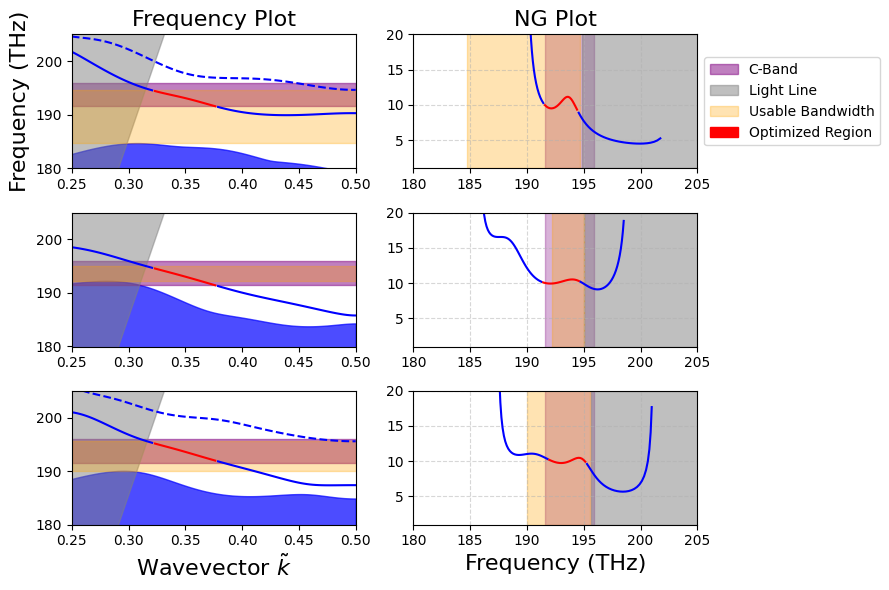

In [276]:
fig, ax = plt.subplots(3,2,figsize=(9,6))
ngs = np.array(ngs)

startk = 29
endk = 51
for i,(gme,ngs) in enumerate(zip(gmes_corrected,ngs_corrected)):

    #find the index that the frequency hits the light line
    light_line_index = np.argmin(np.abs(gme.freqs[:,14]-ks/np.pi/2))

    #get min and max frequency for the bandwidth
    bw_min = np.max(gme.freqs[:,14-1])*fconv_prime
    bw_max = min(np.min(gme.freqs[:,14+1]),gme.freqs[light_line_index,14])*fconv_prime

    #frequency plot
    # Plot the blue line outside [startk, endk]
    ax[i,0].plot(ks[:startk]/np.pi/2, gme.freqs[:startk,14]*fconv_prime, color='b')
    ax[i,0].plot(ks[endk:]/np.pi/2, gme.freqs[endk:,14]*fconv_prime, color='b')
    # Plot the red line within [startk, endk]
    ax[i,0].plot(ks[startk:endk]/np.pi/2, gme.freqs[startk:endk,14]*fconv_prime, color='r')
    # The dashed blue line for the next band
    ax[i,0].plot(ks/np.pi/2, gme.freqs[:,15]*fconv_prime, color='b', linestyle='--')
    ax[i,0].fill_between(ks/np.pi/2, gme.freqs[:,1]*fconv_prime, gme.freqs[:,13]*fconv_prime, color='b', alpha=.7)
    ax[i,0].fill_between(ks/np.pi/2, c_band_min, c_band_max, color='purple', alpha=.5, label='C band')
    ax[i,0].fill_between(ks/np.pi/2, ks*fconv_prime/np.pi/2, np.max(ks)*fconv_prime/np.pi/2, color='gray', alpha=.5)
    ax[i,0].fill_between(ks/np.pi/2, bw_min, bw_max, color='orange', alpha=.3)
    ax[i,0].set_xlim(0.25, 0.5)
    ax[i,0].set_ylim(180, 205)

    #ng plot
    # Plot the blue curve outside [startk, endk]
    ax[i,1].plot(gme.freqs[:startk,14]*fconv_prime, ngs[:startk], color='b')
    ax[i,1].plot(gme.freqs[endk:,14]*fconv_prime, ngs[endk:], color='b')
    # Plot the red curve within [startk, endk]
    ax[i,1].plot(gme.freqs[startk:endk,14]*fconv_prime, ngs[startk:endk], color='r')
    ax[i,1].fill_between(np.linspace(c_band_min, c_band_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='purple', alpha=0.3)
    ax[i,1].fill_between([gme.freqs[light_line_index,14]*fconv_prime,220],[1,1],20,color='gray',alpha=0.5)
    ax[i,1].fill_between(np.linspace(bw_min, bw_max, len(ks)), np.ones(len(ks)), np.max(ngs), color='orange', alpha=0.3)
    ax[i,1].grid(True,linestyle='--',alpha=0.5)
    ax[i,1].set_ylim(1,20)
    ax[i,1].set_xlim(180, 205)

#add labels and legends
ax[0,0].set_ylabel('Frequency (THz)',fontsize=16)
ax[2,1].set_xlabel('Frequency (THz)',fontsize=16)
ax[0,0].set_title('Frequency Plot',fontsize=16)
ax[0,1].set_title('NG Plot',fontsize=16)
ax[2,0].set_xlabel('Wavevector $\\tilde k$',fontsize=16)
# To set custom legend labels and colors, define proxy artists for the legend:
legend_handles = [
    mpatches.Patch(color='purple', alpha=0.5, label='C-Band'),
    mpatches.Patch(color='gray', alpha=0.5, label='Light Line'),
    mpatches.Patch(color='orange', alpha=0.3, label='Usable Bandwidth'),
    mpatches.Patch(color='red', alpha=1, label='Optimized Region')
]
ax[0,1].legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
    

In [277]:
10*(c_band_max/fconv-c_band_min/fconv)

0.06586890187877947

In [286]:
k = ks/2/np.pi
k_start = 29
print(np.argmin(np.abs(k - k[k_start] - 0.07)))

57


In [294]:
np.linspace(29,58,6,dtype=int)

array([29, 34, 40, 46, 52, 58])

In [295]:
print(k[29])

0.32323232323232326
